## Very Fast Simulated Annelling (VFSA)

> Numerical experiment example to show the global optimization of the CRS parameters using VFSA.

In [8]:
from m8r import view

First we need the modeled data cube. 
That process is the same described in the Kirchhoff modeling experiment.
So, we'll skip that, refer to the [modeling experiment directory](https://github.com/Dirack/cre-gather-interpolation/blob/documentation/0.1/experiments/modeling/scons/modeling_Tutorial.ipynb) 
in order to know more details.

In [2]:
%%file 1_errorAndCRSSurfaces.scons 

#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# SConstruct  (Madagascar Script)
#
# Purpose: Exemplify the Very Fast Simulated Annelling Global optimization process
# to obtain the CRS parameters RN, RNIP and BETA from modeled data.
#
# Site: http://www.dirackslounge.online
# 
# Version 1.0
#
# Programer: Rodolfo A. C. Neves (Dirack) 22/09/2019
#
# Email: rodolfo_profissional@hotmail.com
#
# License: GPL-3.0 <https://www.gnu.org/licenses/gpl-3.0.txt>.

# Madagascar library

# Python math library
import math

# Ploting functions
from graph_scons import *

# Modeling: Gaussian reflector in a velocity linear model
# velocity increases with depth and a 0.5 velocity gradient
Flow('gaussianReflector',None,
     '''
     math d1=0.01 n1=2001 o1=-5 unit1=km label1=Offset
     output="4-3*exp(-(x1-5)^2/9)"
     ''')

# Velocity Model
Flow('velocityModel','gaussianReflector',
     '''
     window min1=0 max1=10 |
     spray axis=1 n=451 d=0.01 o=0 label=Depth unit=km |
     math output="1.5+0.5*x1+0.0*x2"
     ''')

# Reflector dip is the derivative of the gaussian function
Flow('reflectorDip','gaussianReflector','math output="2/3*(x1-5)*input" ')

# Kirchoff Modeling
Flow('dataCube','gaussianReflector reflectorDip',
     '''
     kirmod cmp=y dip=${SOURCES[1]} 
     nh=161 dh=0.025 h0=0
     ns=401 ds=0.025 s0=0
     freq=10 dt=0.004 nt=1001
     vel=1.5 gradz=0.5 gradx=0.0 verb=y |
     put d2=0.0125 label3="CMP" unit3="Km" label2="Offset" unit2="Km" label1=Time unit1=s
     ''')

Result('dataCube',grey3('Modeled seismic data cube'))

Writing 1_errorAndCRSSurfaces.scons


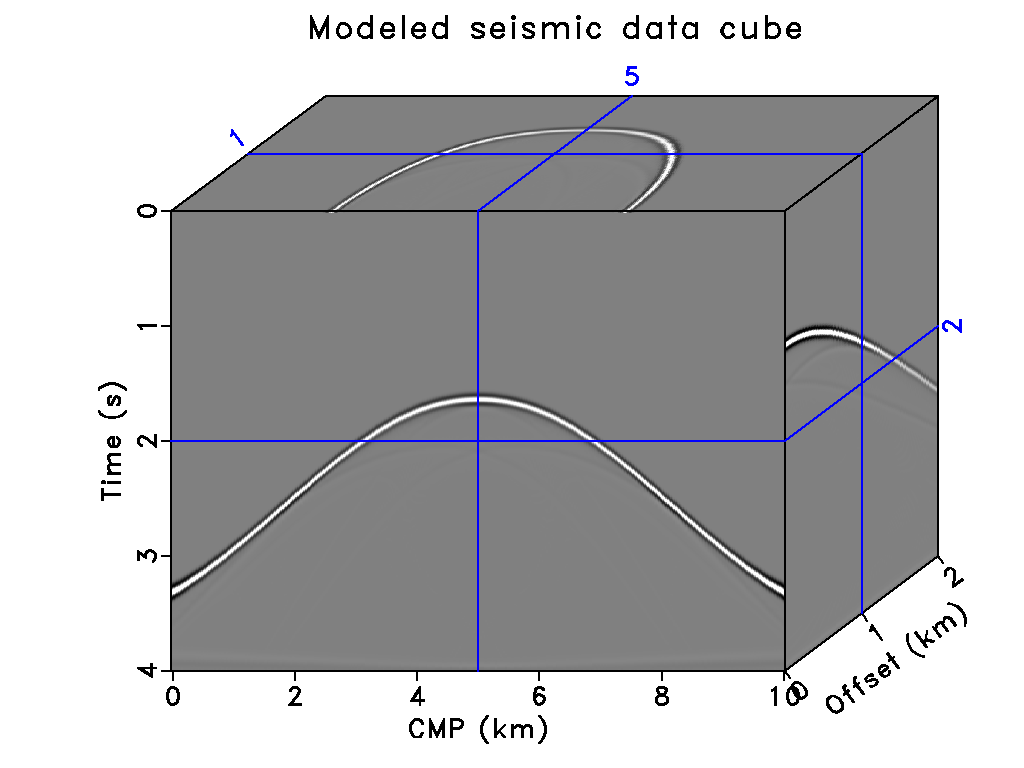

In [3]:
view('dataCube')

We've extracted the traveltime surface from the modeled data cube obtained before to show the difference between the
approximated surface, obtained using a CRS approximation with the CRS paraemters optimized by VFSA, and the modeled one.
The modeled surface is just a 2D representation of the modeled data cube.

In [9]:
%%file 2_reflectionSurface.scons

# Extract the traveltime surface from the data cube
Flow('dataReflectionSurface','dataCube','envelope | max1 | window n1=1 | real')

Plot('dataReflectionSurface',
	'''
	grey color=j bias=2 scalebar=y barlabel=Time barunit=s barreverse=y 
	title="Modeled traveltime surface" label1=Half-Offset unit1=km label2=Midpoint unit2=km
	''')

Result('dataReflectionSurface',
      '''
	grey color=j bias=2 scalebar=y barlabel=Time barunit=s barreverse=y 
	title="Modeled traveltime surface" label1=Half-Offset unit1=km label2=Midpoint unit2=km
	''')


Overwriting 2_reflectionSurface.scons


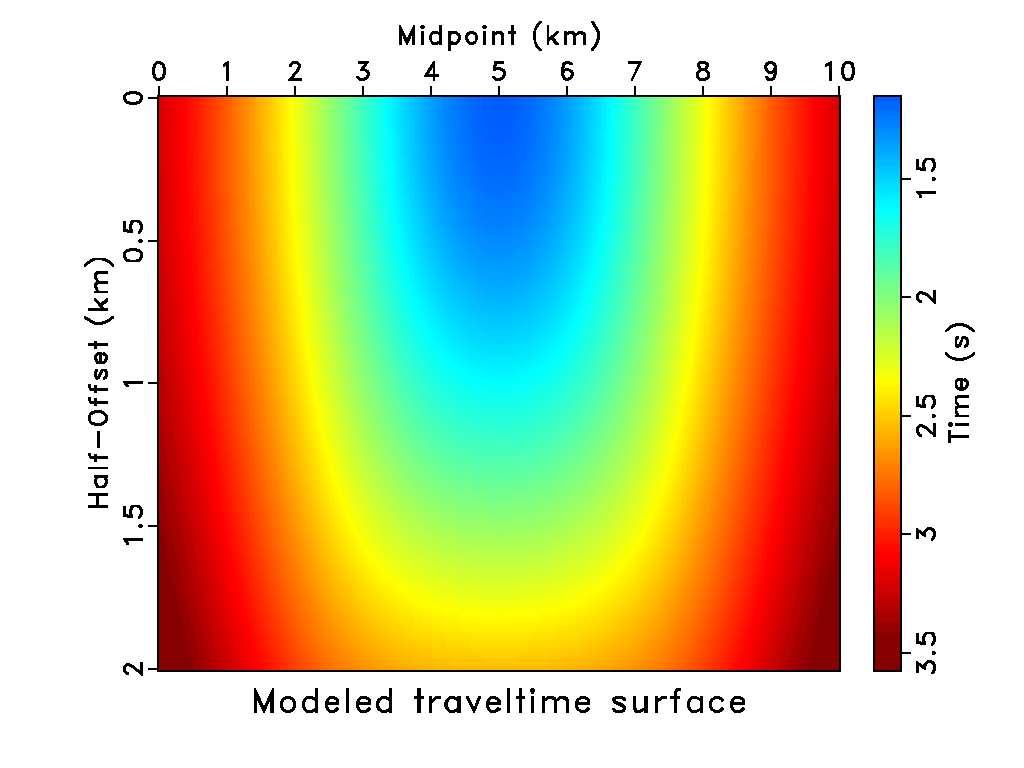

In [10]:
view('dataReflectionSurface')

The VFSA Global Optimization process uses a CRS traveltime approximation to fit the modeled data cube.
As it modifies the approximation 
parameters $R_N, R_{NIP}$ and $\beta_0$ in each iteration,
it measures the coerence between the approximation and modeled data.
The best coerence will be achieved when the CRS approximation fits the data at the best adjust. The 
CRS paramters that produced that adjust are the optimized ones.

The Non-hyperbolic CRS approximation is used in the _sfvfsacrenh_ program. That approximation is discribed in the
paper [Non-hyperbolic CRS](http://www.reproducibility.org/RSF/book/tccs/crs/paper_html/) available on the Madagascar
website.

The program _sfvfsacrenh_ generates a .rsf file with the CRS optimized parameters. We've got to inform to the program
the central CMP of the expansion **m0**, the normal ray traveltime **t0** and the near surface velocity **v0**.

In [11]:
%%file 3_approximatedSurface.scons

m0=5
t0=1.1
v0=1.5

# Very Fast Simulated Aneelling Global Optimization (VFSA)
Flow('crsParameters','dataCube',
	'''
	vfsacrenh m0=%g v0=%g t0=%g verb=y repeat=2
	''' % (m0,v0,t0))

# Plot the approximated traveltime surface
Flow('crsAppSurface',['dataReflectionSurface','crsParameters'],
	'''
	nhcrssurf param=${SOURCES[1]} m0=%g v0=%g t0=%g verb=y
	''' % (m0,v0,t0))

Plot('crsAppSurface',
	'''
	grey color=j bias=2 scalebar=y barlabel=Time barunit=s barreverse=y 
	title="Non-hyperbolic CRS m0=5Km" label1=Half-Offset unit1=km label2=Midpoint unit2=km
	''')

Result('crsAppSurface',
	'''
	grey color=j bias=2 scalebar=y barlabel=Time barunit=s barreverse=y 
	title="Non-hyperbolic CRS m0=5Km" label1=Half-Offset unit1=km label2=Midpoint unit2=km
	''')

Writing 3_approximatedSurface.scons


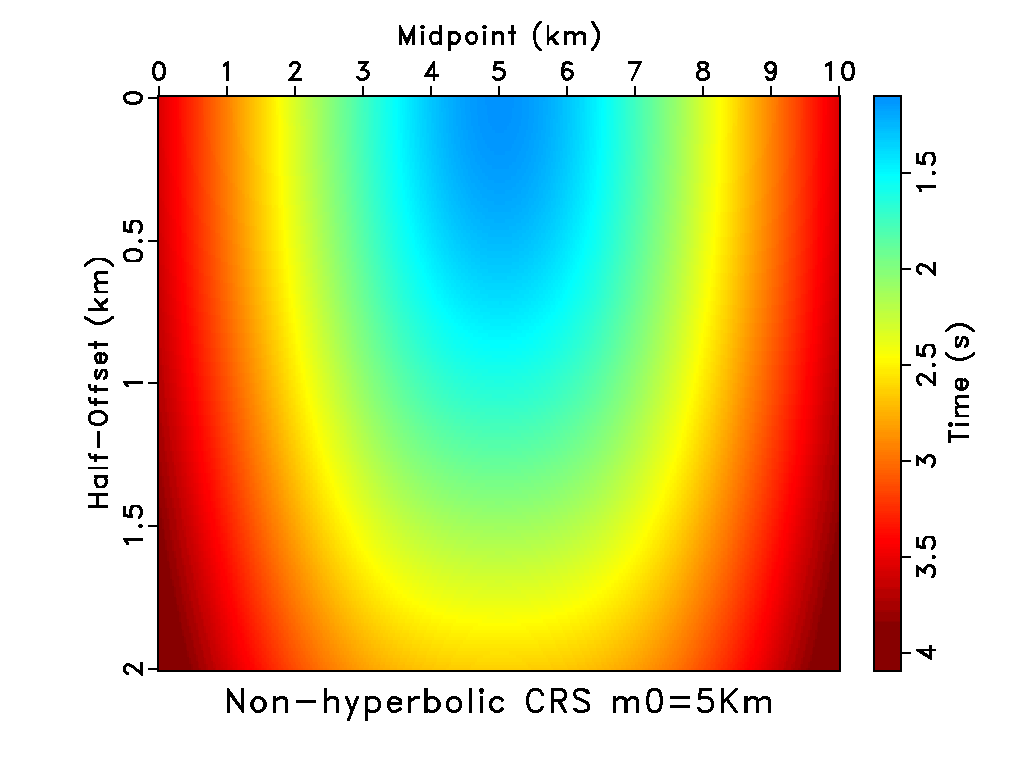

In [12]:
view('crsAppSurface')

To finish, compare the approximated surface with the modeled one. Just use _sfadd_ to calcuate the difference
between then:

In [13]:
%%file 4_error.scons

# Compare approximated with modeled surfaces
Flow('error',['crsAppSurface','dataReflectionSurface'],
	'''
	add scale=1,-1 ${SOURCES[1]} | 
	math output="abs(input)" 
	''')

Plot('error',
	'''
	grey color=j scalebar=y barlabel=Time barunit=s barreverse=y 
	title="Approximation error" label1=Half-Offset unit1=km label2=Midpoint unit2=km
	maxval=1 minval=0
	''')

Result('errorAndCRSSurfaces',['dataReflectionSurface','crsAppSurface','error'],'SideBySideAniso')

Writing 4_error.scons


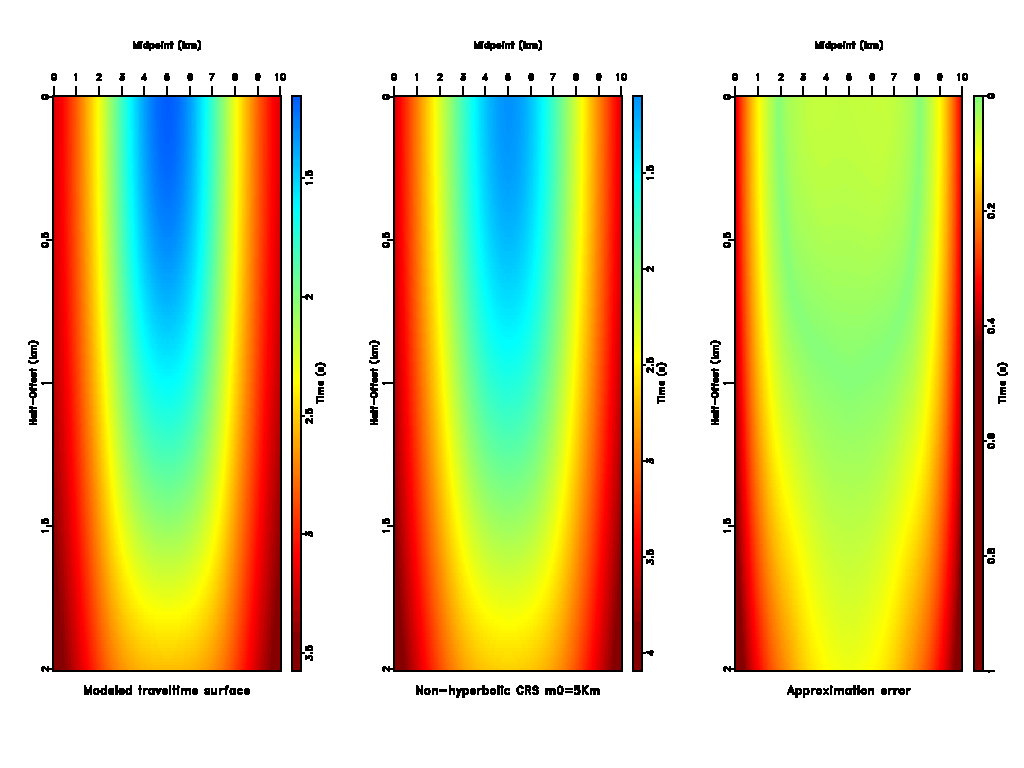

In [14]:
view("errorAndCRSSurfaces")